In [1]:
import pandas as pd
import requests
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic, lonlat
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

In [2]:
file_path1 = '/Users/yokij/Desktop/NYPD_Complaint_Data_Current__Year_To_Date.csv'
data1 = pd.read_csv(file_path1, low_memory=False)
file_path2 = '/Users/yokij/Desktop/NYPD_Complaint_Data_Historic.csv'
data2 = pd.read_csv(file_path2, low_memory=False)
data1 = data1.drop(columns=['New Georeferenced Column'])
df = pd.concat([data1, data2])

In [3]:
#Keep records from January 2018 to May 2023
df['CMPLNT_FR_DT'] = pd.to_datetime(df['CMPLNT_FR_DT'], errors='coerce')
df = df.sort_values(by='CMPLNT_FR_DT', ascending=True)
df = df[(df['CMPLNT_FR_DT'] >= pd.Timestamp('2018-01-01')) & (df['CMPLNT_FR_DT'] <= pd.Timestamp('2023-05-31'))]

In [4]:
#delete data if its category is NaN
df = df[df['KY_CD'].notna()] #KY_CD is more general than PD_CD
df = df[df['LAW_CAT_CD'].notna()] #This records three categories(felony,misdemeanor and violation)
df = df[df['Lat_Lon'].notna()]

In [5]:
df.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
6053750,177774631,23.0,MANHATTAN,2018-01-01,16:00:00,04/03/2018,11:50:00,COMPLETED,(null),(null),...,U,NaN,UNKNOWN,UNKNOWN,E,998751.0,226901.0,40.789463,-73.947634,"(40.7894632995555, -73.9476340039424)"
6058680,178119610,67.0,BROOKLYN,2018-01-01,00:01:00,04/11/2018,14:20:00,COMPLETED,(null),(null),...,(null),NaN,<18,BLACK,F,997843.0,175671.0,40.648851,-73.951017,"(40.6488507469884, -73.951016510623)"
6055205,173133785,43.0,BRONX,2018-01-01,01:58:00,01/01/2018,03:05:00,COMPLETED,(null),(null),...,(null),NaN,<18,WHITE HISPANIC,M,1020219.0,239110.0,40.822912,-73.870041,"(40.8229123084767, -73.8700413043181)"
6054120,178674915,24.0,MANHATTAN,2018-01-01,00:01:00,04/27/2018,12:45:00,COMPLETED,(null),(null),...,U,NaN,UNKNOWN,UNKNOWN,D,993369.0,229307.0,40.796074,-73.967067,"(40.7960743128304, -73.9670667458109)"
6060528,173154147,50.0,BRONX,2018-01-01,19:00:00,01/01/2018,19:45:00,COMPLETED,(null),(null),...,F,NaN,25-44,BLACK HISPANIC,M,1010914.0,260940.0,40.882862,-73.903574,"(40.8828621313214, -73.9035744897024)"


In [6]:
file_path = '/Users/yokij/Desktop/ny_new_york_zip_codes_geo.min.json'
zipcode = gpd.read_file(file_path, low_memory=False)

In [7]:
zipcode.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,36,12205,3612205,B5,G6350,S,40906445,243508,+42.7187855,-073.8292399,N,"POLYGON ((-73.87052 42.75123, -73.86861 42.756..."
1,36,12009,3612009,B5,G6350,S,135241924,2168637,+42.6975663,-074.0355422,N,"POLYGON ((-74.10891 42.65300, -74.10889 42.653..."
2,36,14804,3614804,B5,G6350,S,144718714,232123,+42.3172588,-077.8479358,N,"POLYGON ((-77.92747 42.34775, -77.92632 42.347..."
3,36,14836,3614836,B5,G6350,S,77612958,131305,+42.5429182,-077.8781933,N,"MULTIPOLYGON (((-77.95599 42.47433, -77.95600 ..."
4,36,14536,3614536,B5,G6350,S,47193482,425175,+42.5439751,-078.0836709,N,"POLYGON ((-78.05030 42.53850, -78.05024 42.538..."


In [8]:
# Function to convert string coordinates to Point geometry
def create_point_from_string(coord_str):
    match = re.match(r'\(([^,]+), ([^)]+)\)', coord_str)
    if match:
        lat, lon = map(float, match.groups())
        return Point(lon, lat)
    return None

df['geometry'] = df['Lat_Lon'].apply(create_point_from_string)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)
zipcode.set_crs(epsg=4326, inplace=True)
result = gpd.sjoin(gdf, zipcode, how="left", op='within')

/Users/yokij/opt/anaconda3/lib/python3.9/site-packages/geopandas/sindex.py:87: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (idx, item) in enumerate(geometry.iteritems())


In [9]:
result.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10
6053750,177774631,23.0,MANHATTAN,2018-01-01,16:00:00,04/03/2018,11:50:00,COMPLETED,(null),(null),...,10029,3610029,B5,G6350,S,2136945.0,0.0,+40.7916981,-073.9438757,N
6058680,178119610,67.0,BROOKLYN,2018-01-01,00:01:00,04/11/2018,14:20:00,COMPLETED,(null),(null),...,11226,3611226,B5,G6350,S,3339497.0,0.0,+40.6464480,-073.9566488,N
6055205,173133785,43.0,BRONX,2018-01-01,01:58:00,01/01/2018,03:05:00,COMPLETED,(null),(null),...,10473,3610473,B5,G6350,S,5645604.0,13868.0,+40.8186904,-073.8584741,N
6054120,178674915,24.0,MANHATTAN,2018-01-01,00:01:00,04/27/2018,12:45:00,COMPLETED,(null),(null),...,10025,3610025,B5,G6350,S,1946717.0,0.0,+40.7986009,-073.9666227,N
6060528,173154147,50.0,BRONX,2018-01-01,19:00:00,01/01/2018,19:45:00,COMPLETED,(null),(null),...,10463,3610463,B5,G6350,S,3745408.0,346374.0,+40.8806784,-073.9065404,N


In [10]:
result.set_index('CMPLNT_FR_DT', inplace=True)

In [11]:
weekly_data = result.groupby('ZCTA5CE10').resample('W').size().reset_index(name='total_count')

In [12]:
weekly_geodata = pd.merge(weekly_data, zipcode[['ZCTA5CE10']], on='ZCTA5CE10', how='left')
weekly_geodata.head()

,ZCTA5CE10,CMPLNT_FR_DT,total_count
0,10001,2018-01-07,2
1,10001,2018-01-14,2
2,10001,2018-01-21,0
3,10001,2018-01-28,3
4,10001,2018-02-04,3


In [13]:
weekly_data.to_csv('weekly_data.csv', index=False)

In [36]:
file_path = '/Users/yokij/Desktop/NYC_ACSDP5Y2022DP05.csv'
pop = pd.read_csv(file_path, low_memory=False)

ACS 2022: https://data.census.gov/table/ACSDP5Y2022.DP05?g=160XX00US3651000$8600000

In [37]:
pop.head()

,Label (Grouping),ZCTA5 10451!!Estimate,ZCTA5 10451!!Margin of Error,ZCTA5 10451!!Percent,ZCTA5 10451!!Percent Margin of Error,ZCTA5 10452!!Estimate,ZCTA5 10452!!Margin of Error,ZCTA5 10452!!Percent,ZCTA5 10452!!Percent Margin of Error,ZCTA5 10453!!Estimate,...,ZCTA5 10311!!Percent,ZCTA5 10311!!Percent Margin of Error,ZCTA5 10312!!Estimate,ZCTA5 10312!!Margin of Error,ZCTA5 10312!!Percent,ZCTA5 10312!!Percent Margin of Error,ZCTA5 10314!!Estimate,ZCTA5 10314!!Margin of Error,ZCTA5 10314!!Percent,ZCTA5 10314!!Percent Margin of Error
0,SEX AND AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Total population,"51,311","±2,999","51,311",(X),"78,624","±3,253","78,624",(X),"80,385",...,0,(X),"63,473","±2,814","63,473",(X),"94,355","±2,807","94,355",(X)
2,Male,"23,365","±1,830",45.5%,±2.1,"37,307","±2,085",47.4%,±1.7,"37,656",...,-,**,"31,146","±1,683",49.1%,±1.2,"45,694","±1,697",48.4%,±1.0
3,Female,"27,946","±1,891",54.5%,±2.1,"41,317","±2,156",52.6%,±1.7,"42,729",...,-,**,"32,327","±1,486",50.9%,±1.2,"48,661","±1,684",51.6%,±1.0
4,Sex ratio (males per 100 females),83.6,±7.2,(X),(X),90.3,±6.3,(X),(X),88.1,...,(X),(X),96.3,±4.5,(X),(X),93.9,±3.8,(X),(X)


In [38]:
pop_transposed = pop.transpose()
pop_transposed = pop_transposed.reset_index()
new_header = pop_transposed.iloc[0]  
pop_transposed = pop_transposed[1:]  
pop_transposed.columns = new_header  # Set the header row as the df header

In [39]:
pop_transposed.head()

,Label (Grouping),SEX AND AGE,Total population,Male,Female,Sex ratio (males per 100 females),Under 5 years,5 to 9 years,10 to 14 years,15 to 19 years,...,Native Hawaiian and Other Pacific Islander alone,Some Other Race alone,Two or More Races,Two races including Some Other Race,"Two races excluding Some Other Race, and three or more races",Total housing units,"CITIZEN, VOTING AGE POPULATION","Citizen, 18 and over population",Male,Female
1,ZCTA5 10451!!Estimate,NaN,"51,311","23,365","27,946",83.6,"3,494","3,602","3,571","3,444",...,2,144,680,57,623,"21,335",NaN,"33,190","14,021","19,169"
2,ZCTA5 10451!!Margin of Error,NaN,"±2,999","±1,830","±1,891",±7.2,±796,±666,±660,±620,...,±6,±137,±317,±55,±315,±925,NaN,"±2,153","±1,316","±1,553"
3,ZCTA5 10451!!Percent,NaN,"51,311",45.5%,54.5%,(X),6.8%,7.0%,7.0%,6.7%,...,0.0%,0.3%,1.3%,0.1%,1.2%,(X),NaN,"33,190",42.2%,57.8%
4,ZCTA5 10451!!Percent Margin of Error,NaN,(X),±2.1,±2.1,(X),±1.5,±1.2,±1.2,±1.1,...,±0.1,±0.3,±0.6,±0.1,±0.6,(X),NaN,(X),±2.8,±2.8
5,ZCTA5 10452!!Estimate,NaN,"78,624","37,307","41,317",90.3,"5,461","5,955","6,709","5,901",...,0,881,"1,123",282,841,"28,819",NaN,"45,311","20,727","24,584"


In [40]:
print(pop_transposed.columns)

Index(['Label (Grouping)', 'SEX AND AGE', '    Total population',
       '        Male', '        Female',
       '        Sex ratio (males per 100 females)', '        Under 5 years',
       '        5 to 9 years', '        10 to 14 years',
       '        15 to 19 years', '        20 to 24 years',
       '        25 to 34 years', '        35 to 44 years',
       '        45 to 54 years', '        55 to 59 years',
       '        60 to 64 years', '        65 to 74 years',
       '        75 to 84 years', '        85 years and over',
       '        Median age (years)', '        Under 18 years',
       '        16 years and over', '        18 years and over',
       '        21 years and over', '        62 years and over',
       '        65 years and over', '        18 years and over',
       '            Male', '            Female',
       '            Sex ratio (males per 100 females)',
       '        65 years and over', '            Male', '            Female',
       '            

In [41]:
df = pop_transposed
df.columns = df.columns.str.strip()

if 'level_0' in df.columns:
    df.drop('level_0', axis=1, inplace=True)
df.reset_index(inplace=True)

df_estimates = df[df['Label (Grouping)'].str.contains('!!Estimate')]
df_estimates = df_estimates[['Label (Grouping)', 'Total population']]
df_estimates.set_index(df_estimates['Label (Grouping)'].str.replace('!!Estimate', ''), inplace=True)
df_estimates.drop('Label (Grouping)', axis=1, inplace=True)
pop = df_estimates.reset_index(drop=False)
pop.head()

,Label (Grouping),Total population,Total population,Total population,Total population
0,ZCTA5 10451,"51,311","51,311","51,311","51,311"
1,ZCTA5 10452,"78,624","78,624","78,624","78,624"
2,ZCTA5 10453,"80,385","80,385","80,385","80,385"
3,ZCTA5 10454,"41,073","41,073","41,073","41,073"
4,ZCTA5 10455,"44,380","44,380","44,380","44,380"


In [42]:
pop['ZCTA5CE10'].nunique()

KeyError: 'ZCTA5CE10'

In [43]:
pop = pop.rename(columns={"Label (Grouping)": "ZCTA5CE10"})
pop['ZCTA5CE10'] = pop['ZCTA5CE10'].str.replace('ZCTA5 ', '')
pop = pop.iloc[:, [0, 1]]  # Keeps only the first two columns
pop.head()

,ZCTA5CE10,Total population
0,10451,"51,311"
1,10452,"78,624"
2,10453,"80,385"
3,10454,"41,073"
4,10455,"44,380"


In [44]:
merged_df = pd.merge(weekly_geodata, pop, on='ZCTA5CE10', how='left')
merged_df.head()

,ZCTA5CE10,CMPLNT_FR_DT,total_count,Total population
0,10001,2018-01-07,2,"27,004"
1,10001,2018-01-14,2,"27,004"
2,10001,2018-01-21,0,"27,004"
3,10001,2018-01-28,3,"27,004"
4,10001,2018-02-04,3,"27,004"


In [45]:
merged_df['Total population'] = pd.to_numeric(merged_df['Total population'].str.replace(',', ''), errors='coerce').fillna(0).astype(int)
merged_df['crime_rate'] = (merged_df['total_count'] / merged_df['Total population']) * 10000
merged_df = merged_df.rename(columns={'Total population': "total_population"})
merged_df = merged_df.rename(columns={"CMPLNT_FR_DT": "week"})

In [46]:
merged_df.head()

,ZCTA5CE10,week,total_count,total_population,crime_rate
0,10001,2018-01-07,2,27004,0.740631
1,10001,2018-01-14,2,27004,0.740631
2,10001,2018-01-21,0,27004,0.000000
3,10001,2018-01-28,3,27004,1.110947
4,10001,2018-02-04,3,27004,1.110947


In [47]:
merged_df = merged_df[merged_df['total_population'] != 0]

In [48]:
merged_df['ZCTA5CE10'].nunique()

184

In [49]:
merged_df.shape

(48866, 5)

In [50]:
merged_df.to_csv('weekly_data.csv', index=False)

In [51]:
df_plot = merged_df
df_plot.set_index('week', inplace=True)

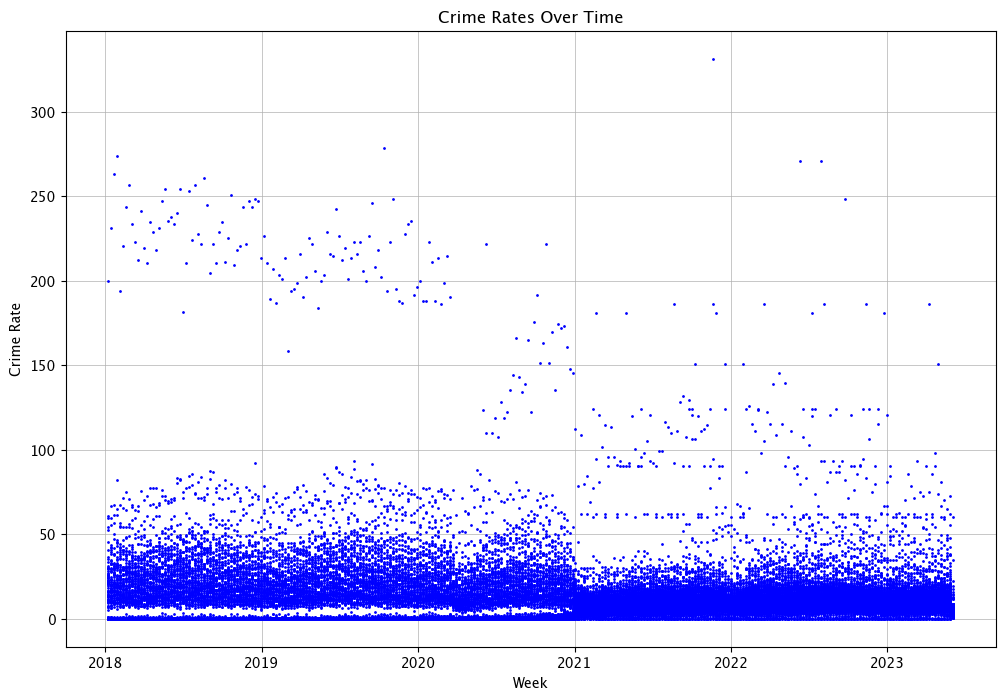

In [52]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(df_plot.index, df_plot['crime_rate'], marker='o', linestyle='None', color='b', markersize=1)

plt.title('Crime Rates Over Time')
plt.xlabel('Week')
plt.ylabel('Crime Rate')
plt.grid(True, linewidth=0.5)
plt.show()

In [53]:
statistics = merged_df.describe().T
print(statistics)

                    count          mean           std    min           25%  \
total_count       48866.0     51.686244     56.325672    0.0      1.000000   
total_population  48866.0  48791.981500  26655.030993  161.0  28137.000000   
crime_rate        48866.0     11.460642     17.126527    0.0      0.334158   

                           50%           75%            max  
total_count          36.000000     86.000000     458.000000  
total_population  43653.000000  69755.000000  112750.000000  
crime_rate            8.267196     15.081704     331.325301  


In [54]:
print(merged_df['total_count'].median())
print(merged_df['total_population'].median())
print(merged_df['crime_rate'].median())

36.0
43653.0
8.267195767195767


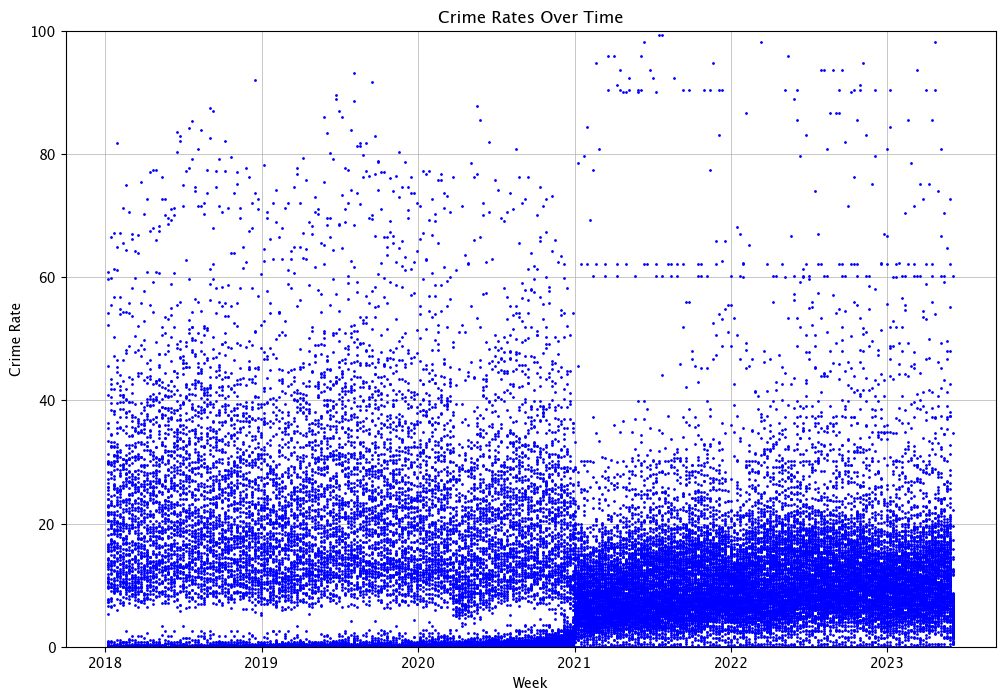

In [56]:
# zoom in
plt.figure(figsize=(12, 8))
plt.plot(df_plot.index, df_plot['crime_rate'], marker='o', linestyle='None', color='b', markersize=1)

plt.ylim(0, 100)

plt.title('Crime Rates Over Time')
plt.xlabel('Week')
plt.ylabel('Crime Rate')
plt.grid(True, linewidth=0.5)
plt.show()